<a href="https://colab.research.google.com/github/pangpang97/shap_tutorial/blob/main/shap_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `SHAP Tutorial`

本文主要介绍：


*   SHAP的原理
*   SHAP的应用方式



## SHAP的介绍

SHAP的目标就是通过计算每个样本中每一个特征对prediction的贡献, 来对模型结果做解释。在合作博弈论的启发下SHAP构建一个加性的解释模型，所有的特征都视为“贡献者”。对于每个预测样本，模型都产生一个预测值，SHAP值就是该样本中每个特征所分配到的数值。

设第$i$个样本为$x_i$，第$i$个样本的第$j$个特征为$x_i^j$，模型对该样本的预测值为$y_i$，整个模型的基线（通常是所有样本的目标变量的均值）为$y_{base}$，那么SHAP值服从以下等式：

$y_i = y_{base} + f(x_i^1)+f(x_i^2)+...+f(x_i^j)$


其中$f(x_i^j)$为$x_i^j$的SHAP值。直观上看，$f(x_i^1)$就是第$i$个样本中第1个特征对最终预测值$y_i$的贡献值，当$f(x_i^1)>0$，说明该特征提升了预测值，也正向作用；反之，说明该特征使得预测值降低，有反作用。上式是也是通过拟合的方式获得$f(x_i^j)$的值。具体的是如何拟合的这里不做要求。

## 以树模型TreeSHAP为例子说明SHAP值的用法

这个教材以Titantic数据为例子进行说明
下面简单看下titantic的特征: 


PassengerId 乘客ID


Survived 获救与否(0死亡,1生存)


Pclass 乘客等级(1/2/3等舱位)


Name 乘客姓名


Sex 性别


Age 年龄


SibSp 堂兄弟/妹个数


Parch 父母与小孩个数


Ticket 船票信息


Fare 票价


Cabin 客舱


Embarked 登船港口


这是一个二分类问题，其中Survived是要预测的值， Pclass，Sex，Age，SibSp，Parch，Ticket，Fare，Cabin，Embarked为特征


我们将以集成树模型（LightGBM为例来讲解）


注：我们尽量简化这个问题，方便大家理解shap是如何应用的。

In [1]:
#拉取数据
!git clone https://github.com/pangpang97/shap_tutorial

Cloning into 'shap_tutorial'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [2]:
#引入需要的包
import pandas as pd
import numpy as np
all_data = pd.read_csv('shap_tutorial/train_titantic.csv')
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### 简单的数据处理



In [3]:
#删去暂时不要的列
all_data.drop(['PassengerId','Name'], axis=1, inplace=True)
#填充缺失值
all_data['Age'].fillna(0, inplace=True)
all_data['Cabin'].fillna('UNK', inplace=True)
all_data['Embarked'].fillna('UNK', inplace=True)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     891 non-null    object 
 9   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB


In [4]:
#把Sex，Ticket，Cabin和Embarked做一个lebel encoding
from sklearn.preprocessing import LabelEncoder
cate_cols = ['Sex','Ticket','Cabin','Embarked']
for cc in cate_cols:
    enc = LabelEncoder()
    all_data[cc] = enc.fit_transform(all_data[cc])

### LightGBM训练




In [5]:
#拆分下训练集和测试集
from sklearn.model_selection import train_test_split
train, test = train_test_split(all_data,test_size=0.2)

#利用LightGBM训练模型
import lightgbm as lgb
from sklearn import metrics
params = {'objective': 'binary',
          'metric': 'binary_logloss',
          'num_round': 80,
          'verbose':1
              }
num_round = params.pop('num_round',1000)
xtrain = lgb.Dataset(train.drop(columns=['Survived']), train['Survived'],free_raw_data=False)
xeval = lgb.Dataset(test.drop(columns=['Survived']), test['Survived'],free_raw_data=False)
evallist = [xtrain, xeval]
clf = lgb.train(params, xtrain, num_round, valid_sets=evallist)
ytrain = np.where(clf.predict(train.drop(columns=['Survived']))>=0.5, 1,0)
ytest = np.where(clf.predict(test.drop(columns=['Survived']))>=0.5, 1,0)
print("train classification report")
print(metrics.classification_report(train['Survived'], ytrain))
print('*'*60)
print("test classification report")
print(metrics.classification_report(test['Survived'], ytest))

[1]	training's binary_logloss: 0.616752	valid_1's binary_logloss: 0.628188
[2]	training's binary_logloss: 0.577503	valid_1's binary_logloss: 0.59757
[3]	training's binary_logloss: 0.545282	valid_1's binary_logloss: 0.573299
[4]	training's binary_logloss: 0.517894	valid_1's binary_logloss: 0.55145
[5]	training's binary_logloss: 0.49365	valid_1's binary_logloss: 0.53399
[6]	training's binary_logloss: 0.472167	valid_1's binary_logloss: 0.518513
[7]	training's binary_logloss: 0.453641	valid_1's binary_logloss: 0.506068
[8]	training's binary_logloss: 0.437905	valid_1's binary_logloss: 0.494044
[9]	training's binary_logloss: 0.424174	valid_1's binary_logloss: 0.485643
[10]	training's binary_logloss: 0.410632	valid_1's binary_logloss: 0.477679
[11]	training's binary_logloss: 0.398761	valid_1's binary_logloss: 0.470235
[12]	training's binary_logloss: 0.388724	valid_1's binary_logloss: 0.464987
[13]	training's binary_logloss: 0.379662	valid_1's binary_logloss: 0.460591
[14]	training's binary_lo

## SHAP值的常规用法



In [6]:
!pip install shap
import warnings
warnings.filterwarnings("ignore")
import shap
shap.initjs()

     |████████████████████████████████| 564 kB 3.6 MB/s 


In [7]:
#如果数据量大，这个运行的会非常慢
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(train.drop(columns=['Survived'])) #获取shap value
np.array(shap_values).shape #看一下shap value的dim

(2, 712, 9)

shap值是一个三维的数据。一个样本有两个shap值。

第一个维度控制的是选择哪个类别的shap值，第一个维度是0表示0（negative）类，第一个维度是1表示1（positive）类。

后面两个维度就是每个样本和每个特征的shap值。

In [8]:
(shap_values[0] == -1* shap_values[1]).all()

True

可以看到0类的shap值和1类的shap值是相反的

### 单个样本的shap值

可能的应用场景： 

*   分析bad case：分析分错样本和分对的样本差异
*   业务向的分析：例如，在流失场景中分析用户流失的具体原因


我们以看第一个样本的正类的shap值为例



In [9]:
train.drop(columns=['Survived']).iloc[0].T

Pclass        3.0000
Sex           1.0000
Age          20.0000
SibSp         1.0000
Parch         1.0000
Ticket      187.0000
Fare         15.7417
Cabin       147.0000
Embarked      0.0000
Name: 622, dtype: float64

In [10]:
#查看单个样本的特征贡献的第一种方法
shap.initjs()# colab需要在每个cell上运行这个命令，如果你是jupyter notebook或jupyter lab可以把这行注释掉
shap.plots.force(explainer.expected_value[1],shap_values[1][0],train.drop(columns=['Survived']).iloc[0])

上面的图表示的是： 对一个样本来说，各个特征是如何把预测值从base value推到f(x)(最终的输出值)的。说明了各个特征的贡献。红色的表示向正向（往右）推动预测值；蓝色的表示向正负（往左）推动预测值的。每个特征图块的大小表示shap值的大小。base value是指的模型对训练集的所有样本的（这个参考资料中都没有明确说明 这个是我试出来的）预测值的均值。对于回归问题就是均值，如果对于分类问题是每个类别的均值。是`explainer.expected_value`的值。

In [11]:
#看一下base value
explainer.expected_value

[0.908824118858436, -0.908824118858436]

因为是分类问题，所以explainer.expected_value有两个值，第一个是0类预测均值，第二个是1类的均值。 SHAP对于xgboost和lightgbm取的是对数几率转换. 还有个问题需要注意下

In [12]:
y_train_prob = clf.predict(train.drop(columns=['Survived']))
print('shap base value:', explainer.expected_value[1], ' 取log的预测值的均值：',np.log(y_train_prob/ (1 - y_train_prob)).mean())

shap base value: -0.908824118858436  取log的预测值的均值： -0.9088241188584363


可以看到上面的结果，shap的base value和取log的预测值的均值是基本相等的。 如果看的是test的shap 取log的预测值就会和base value有明显差异。

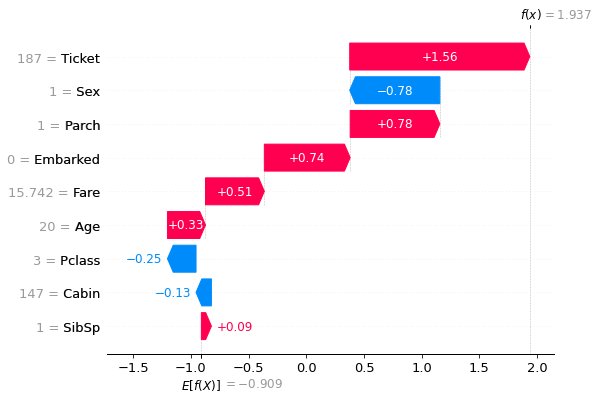

In [13]:
#查看单个样本的特征贡献的第二种方法
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values[1][0],train.drop(columns=['Survived']).iloc[0])

这个图的意思跟`shap.plots.force()`方法是一样的，但是我感觉看起来更加的直观。

这个方法是替代`shap.plots.waterfall()`和`shap.plots.waterfall()`方法的。 这俩方法会报错。

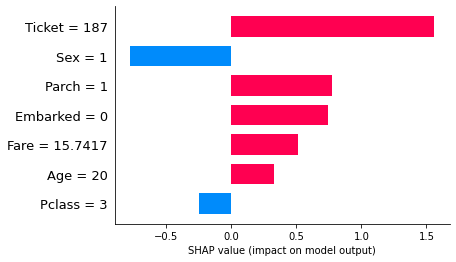

In [14]:
#查看单个样本的特征贡献的第三种方法
shap.bar_plot(shap_values[1][0],train.drop(columns=['Survived']).iloc[0])

这个图跟前面两个是很相似的。但是没有标记base value和f(x)(最终的预测值)

### 多个样本的shap值

In [15]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1],train.drop(columns=['Survived']))#我们看下训练集所有样本的特征贡献情况

这个图是训练集的所有样本的特征贡献情况，用鼠标华东可以看每一个样本的情况。

横坐标：可以按照多种指标将样本排序，包括： 样本的相似性（就是把相似的样本排在一起），样本输出结果，原始样本顺序，各个特征值；


纵坐标：可以按照最终的预测值以及各个各种的贡献值排序

### 模型整体情况（特征重要性）

可能的应用场景：

*   分析模型的特征，帮助特征筛选和特征工程
*   模型异常时分析是否有特征穿越
*   业务分析： 例如，在流失场景中分析，哪些因素是用户流失的主要原因

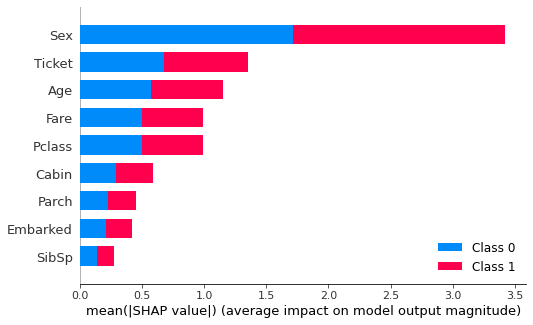

In [16]:
shap.summary_plot(shap_values, train.drop(columns=['Survived']),plot_type="bar")

这既是利用shap值做的特征重要性的图。 这个是每个样本的0类和1类的shap值分别取绝对值再求平均得到的。

这里分别展示了0类和1类的特征重要性。通过上面的分析知道，0类的shap值和1类的shap值的绝对值是一样的。所以理论上只看一个就行了。

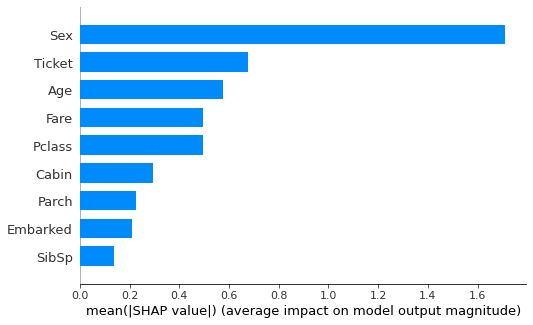

In [17]:
shap.summary_plot(shap_values[1], train.drop(columns=['Survived']),plot_type="bar")

这个是我们经常用到的特征重要性。 

这个的计算方式和上面是一样的，只不过只取了1类的shap值。

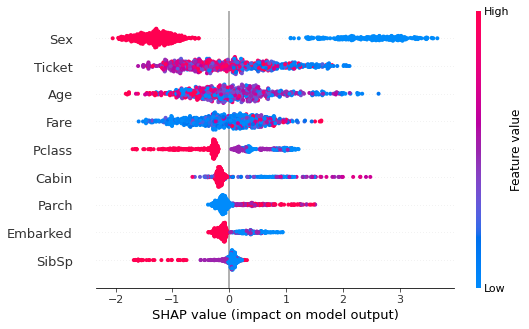

In [18]:
shap.summary_plot(shap_values[1], train.drop(columns=['Survived']))

这个可以看作是特征重要性的细致版本。这里为每个样本绘制其每个特征的SHAP值，这可以更好地理解整体模式，并允许发现预测异常值。每一行代表一个特征，横坐标为SHAP值。一个点代表一个样本，颜色表示特征值(红色高，蓝色低)。

例如：性别（Sex）为例，Sex=1的shap值要小于Sex=0的shap值。联系到这个问题可以分析出来，Sex=0（即性别是female）更容易活下来（Survivied=1）。同理发现 乘客等级越低（Pclass值越大，shap值越小，越难以活下来。

### 单个特征与预测结果的关系

可能的应用场景：

*   分析连续特征与预测的关系（是否有线性和非线性的关系），帮助连续特征离散化

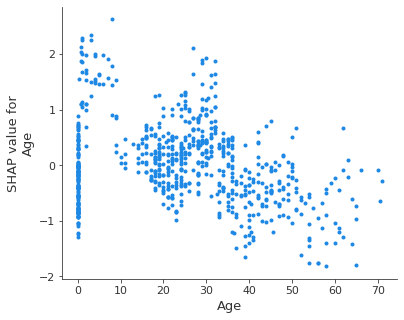

In [19]:
shap.dependence_plot('Age', shap_values[1], train.drop(columns=['Survived']),interaction_index=None)

如图，横坐标是特征（Age）的值，纵坐标是对应的shap值，整体的趋势是先下降后升高的。这说明小孩子和老人更容易活下来。

### 多个特征与预测结果的关系

可能的应用场景：

*   分析特征组合与预测的关系，判断两个特征是否有可能组成更好的特征

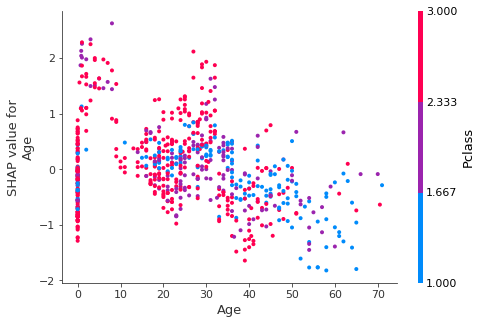

In [20]:
shap.dependence_plot('Age', shap_values[1], train.drop(columns=['Survived']),interaction_index='Pclass')

如图，横坐标是特征（Age）的值，纵坐标是对应的shap值，颜色的深浅代表Pclass。

从图中可以看出来，在乘客级别较低的地方，年纪大的人更容易活下来。



### 其他

SHAP不仅仅有TreeExplainer，还有其他的Explainer：


*   TreeExplainer : 适合XGBoost, LightGBM, CatBoost以及scikit-learn models里的树模型
*   DeepExplainer (DEEP SHAP) : 适合TensorFlow and Keras models的模型
*   GradientExplainer : 适合TensorFlow and Keras models的模型
*   KernelExplainer: 适合任何的model







### 深度学习使用SHAP

In [22]:
import pandas as pd
import numpy as np
all_data = pd.read_csv('shap_tutorial/train_titantic.csv')

#删去暂时不要的列
all_data.drop(['PassengerId','Name'], axis=1, inplace=True)
#填充缺失值
all_data['Age'].fillna(0, inplace=True)
all_data['Cabin'].fillna('UNK', inplace=True)
all_data['Embarked'].fillna('UNK', inplace=True)

#把Sex，Ticket，Cabin和Embarked做一个lebel encoding
from sklearn.preprocessing import LabelEncoder
cate_cols = ['Sex','Ticket','Cabin','Embarked']
cate_features = {}
cate_cnt ={}
for cc in cate_cols:
    enc = LabelEncoder()
    all_data[cc] = enc.fit_transform(all_data[cc])
    cate_cnt[cc] = all_data[cc].max()

cate_cnt['Parch'] = all_data['Parch'].max()
cate_cnt['Pclass'] = all_data['Pclass'].max()
cate_cnt['SibSp'] = all_data['SibSp'].max()

In [23]:
cate_cnt

{'Cabin': 147,
 'Embarked': 3,
 'Parch': 6,
 'Pclass': 3,
 'Sex': 1,
 'SibSp': 8,
 'Ticket': 680}

In [24]:
#拆分下训练集和测试集
use_cols = ['Cabin','Embarked','Parch','Pclass','Sex','SibSp','Ticket']
from sklearn.model_selection import train_test_split
y = all_data['Survived']
X = all_data.copy()
X.drop(columns=['Survived'], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [26]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import *
from tensorflow.keras import Input
from tensorflow.keras import Model

def mlp(train, use_cols):
    input_list = []
    emb_list = []
    for c in train.columns:
        input_list.append(Input(shape=(1,),name=c))
        if c in use_cols:
            #需要做embedding
            emb_feature = Flatten()(Embedding(input_dim=train[c].max()+1, output_dim=4)(input_list[-1]))
        else:
            emb_feature = input_list[-1]
        emb_list.append(emb_feature)
    #concate all input
    all_in = Concatenate()(emb_list)
    hidden = Dense(32,activation='relu')(all_in)
    hidden = Dense(16, activation='relu')(hidden)
    hidden = Dense(8, activation='relu')(hidden)
    y = Dense(1, activation='sigmoid')(hidden)
    #model
    model = Model(inputs=input_list, outputs=[y])
    return model

2.7.0


In [30]:
model = mlp(X, use_cols)
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['acc'])
model.fit([X_train[c] for c in X_train.columns], y_train, epochs=18, batch_size=32, validation_data=([X_test[c] for c in X_test.columns], y_test))

Epoch 1/18
23/23 [==============================] - 4s 26ms/step - loss: 1.4307 - acc: 0.4789 - val_loss: 0.7328 - val_acc: 0.6536
Epoch 2/18
23/23 [==============================] - 0s 8ms/step - loss: 0.6792 - acc: 0.6362 - val_loss: 0.6359 - val_acc: 0.6704
Epoch 3/18
23/23 [==============================] - 0s 9ms/step - loss: 0.6378 - acc: 0.6657 - val_loss: 0.6211 - val_acc: 0.6760
Epoch 4/18
23/23 [==============================] - 0s 11ms/step - loss: 0.6203 - acc: 0.6924 - val_loss: 0.6124 - val_acc: 0.6927
Epoch 5/18
23/23 [==============================] - 0s 10ms/step - loss: 0.6074 - acc: 0.6882 - val_loss: 0.6106 - val_acc: 0.7039
Epoch 6/18
23/23 [==============================] - 0s 12ms/step - loss: 0.5984 - acc: 0.6924 - val_loss: 0.6007 - val_acc: 0.7151
Epoch 7/18
23/23 [==============================] - 0s 12ms/step - loss: 0.5701 - acc: 0.7233 - val_loss: 0.5816 - val_acc: 0.7207
Epoch 8/18
23/23 [==============================] - 0s 14ms/step - loss: 0.5453 - acc

In [31]:
from sklearn import metrics
ytrain_pred = np.where(model.predict([X_train[c] for c in X_train.columns])>=0.5, 1,0)
ytest_pred = np.where(model.predict([X_test[c] for c in X_test.columns])>=0.5, 1,0)
print("train classification report")
print(metrics.classification_report(y_train, ytrain_pred))
print('*'*60)
print("test classification report")
print(metrics.classification_report(y_test, ytest_pred))

train classification report
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       437
           1       0.97      0.84      0.90       275

    accuracy                           0.93       712
   macro avg       0.94      0.91      0.92       712
weighted avg       0.93      0.93      0.93       712

************************************************************
test classification report
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       112
           1       0.86      0.72      0.78        67

    accuracy                           0.85       179
   macro avg       0.85      0.82      0.83       179
weighted avg       0.85      0.85      0.85       179



In [32]:
!pip install shap
import warnings
warnings.filterwarnings("ignore")
import shap
shap.initjs()

In [33]:
def f(X):
    return model.predict([X[:,i] for i in range(X.shape[1])]).flatten()

In [51]:
#这个Explainer非常的慢，大概需要运行3分钟。如果数据量更大，时间会更长。这个比TreeExplainer慢很多。
explainer = shap.KernelExplainer(f, X_train.iloc[:10]) #用十个样本去评估，如果用所有的数据，会很慢
shap_values = explainer.shap_values(X_train) #获取shap value
np.array(shap_values).shape #看一下shap value的dim

  0%|          | 0/712 [00:00<?, ?it/s]

(712, 9)

In [52]:
print(X_train.iloc[0,:])
print('Survived ', y_train.iloc[0])

Pclass        3.0000
Sex           1.0000
Age          29.0000
SibSp         1.0000
Parch         0.0000
Ticket      315.0000
Fare          7.0458
Cabin       147.0000
Embarked      2.0000
Name: 477, dtype: float64
Survived  0


注意这里是2维的

In [53]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_train.iloc[0,:])

In [54]:
y_train_prob = model.predict([X_train[c] for c in X_train.columns])
print('shap base value:',explainer.expected_value, ' mean of prediction: ',np.mean(y_train_prob[:10]))#上面的Explainer用了多少数据去评估，base value就是多少个样本的预测值的平均

shap base value: 0.1138872653245926  mean of prediction:  0.113887265


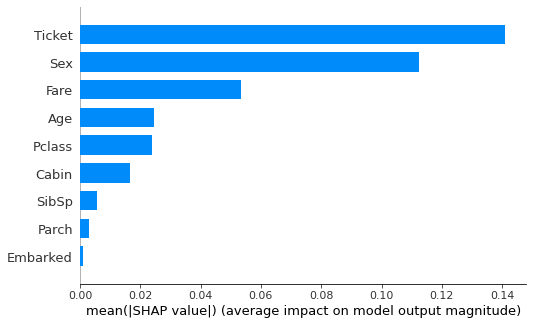

In [55]:
shap.summary_plot(shap_values, X_train,plot_type="bar")

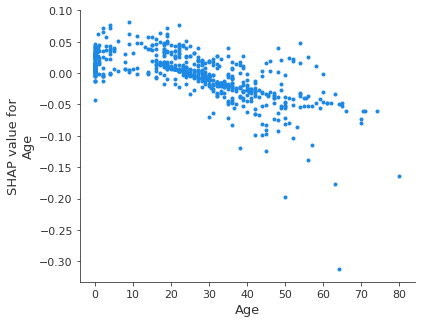

In [56]:
shap.dependence_plot('Age', shap_values, X_train,interaction_index=None)

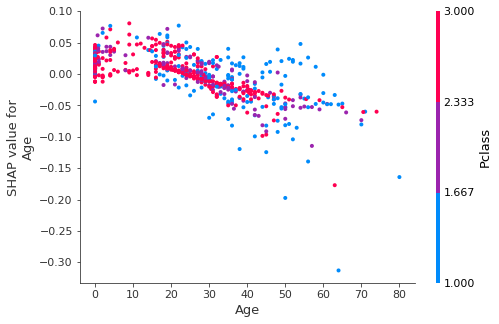

In [57]:
shap.dependence_plot('Age', shap_values, X_train,interaction_index='Pclass')

## Reference

*   [SHAP python包的官网](https://shap.readthedocs.io/en/latest/index.html)

*   [SHAP的github](https://github.com/slundberg/shap)

*   [SHAP介绍，可以看实战演示部分](https://zhuanlan.zhihu.com/p/106320452)

